In [ ]:
! git clone https://github.com/deep-floyd/IF.git

In [ ]:
! pip install diffusers accelerate transformers safetensors


In [10]:
!pip install omegaconf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144552 sha256=c666b175bca6d15f41d5191a31f06746da855cce7547973ffaacc84fb289b3d0
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [ ]:
!pip install deepfloyd_if==1.0.2rc0 xformers==0.0.16  git+https://github.com/openai/CLIP.git --no-deps

In [ ]:
!pip install ftfy

In [ ]:
!pip install huggingface_hub --upgrade


In [ ]:
from huggingface_hub import login

login()

In [10]:
from IF.deepfloyd_if.modules import IFStageI, IFStageII, StableStageIII
from IF.deepfloyd_if.modules.t5 import T5Embedder

device = 'cuda:0'
if_I = IFStageI('IF-I-XL-v1.0', device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1104: FutureWarning: The `force_filename` parameter is deprecated as a new caching system, which keeps the filenames as they are on the Hub, is now in place.
  warnings.warn(


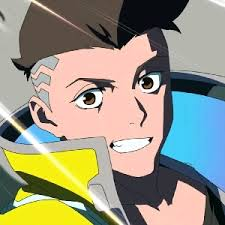

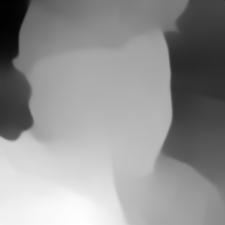

In [5]:
#prepare dataset
from PIL import Image
import torchvision.transforms as transforms

# Open an image file
image = Image.open('david.jpg')
depth = Image.open('david_depth.jpg')
display(image,depth)
# Define a transformation that converts the image to a tensor
transform = transforms.ToTensor()

# Apply the transformation to the image
image_tensor = [transform(image)]
depth_tensor= [transform(depth)]

In [2]:
class config:
  num_epochs = 50
  gradient_accumulation_steps = 1
  learning_rate = 1e-4
  lr_warmup_steps = 500
  save_image_epochs = 10
  save_model_epochs = 30
  mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
  output_dir = "deepflod-depth"  # the model name locally and on the HF Hub

In [6]:
import torch
from torch.utils.data import Dataset
class trainDataset(Dataset):
    def __init__(self, image,depth):
        self.image=image
        self.depth=depth

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        return self.image[idx],self.depth[idx]

In [ ]:
train_data=trainDataset(image_tensor,depth_tensor)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
model=if_I.model()

In [ ]:
import torch
from PIL import Image
from diffusers import DDPMScheduler,DDPMPipeline

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
from diffusers.optimization import get_cosine_schedule_with_warmup
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [ ]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
       if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
       accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images,depth_images,prompt = batch[0],batch[1],batch[2]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]
            emd=text_encoder(prompt)
            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images,depth_images,emd,timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
    pipeline.save_pretrained(config.output_dir)